<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_RegressionLineaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place une regression linéaire à l'aide d'un réseau de neurones sur notre série temporelle. Pour cela, nous allons suivre les étapes suivantes :
  - Reprendre le code nécessaire pour créer notre série temporelle
  - Définir une fonction permettant de préparer les données d'entrée X et les labels Y pour attaquer notre réseau de régression linéaire
  - Préparer les données X et Y avec la fonction définie précédemment.
  - Construire un réseau de neurones pour réaliser une régression linéaire
  - Entrainer le modèle avec les données X et Y
  - Réaliser des prédictions sur la série temporelle avec notre modèle
  - Mesurer les erreurs

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

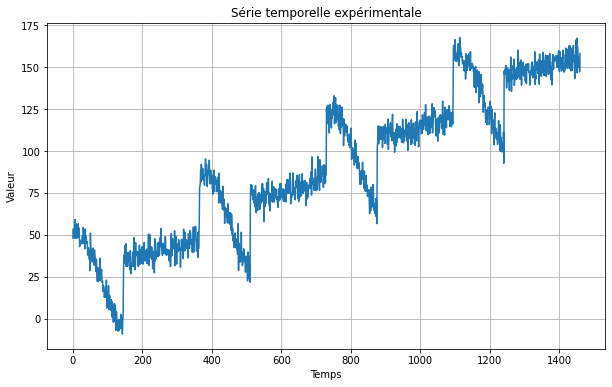

In [3]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

Regardons le format de la série temporelle que nous avons pour le moment :

In [ ]:
print(serie.shape)
print(serie[0:5])

(1460,)
[51.28338563 44.08280687 51.50709973 53.3739123  64.2633703 ]


# Préparation des données X et Y

Définissons la fonction `prepare_dataset_XY` qui va permettre de créer les données X Y pour le réseau de neurones. Cette fonction retourne une classe Dataset et prend comme  paramètres :
 - `serie` : La série temporelle à traiter
 - `taille_fenetre` : La taille de la fenêtre glissante
 - `batch_size` : La nombre de regroupements que l'on souhaite obtenir dans nos données X et Y : par exemple si X=(X1,X2) et Y=(Y1,Y2) alors il faut donner `batch_size = 2`
 - `buffer_melange` : Buffer pour le mélange des données  
   

Cette fonction utilise la méthode [from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) de la classe Dataset de Tensorflow afin d'extraire une coupe depuis la série originale et de créer un dataset dont les éléments sont les valeurs de la série :

In [4]:
# Création d'un dataset à partir de la série temporelle
dataset = tf.data.Dataset.from_tensor_slices(serie)

# Affichage  des 5 premiers éléments du dataset
for vecteur in dataset.take(5):
  print(vecteur.numpy())

48.03517683156818
49.08330343972117
53.563953154449344
49.51626107828481
53.74075140981713


In [5]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Regardons un exemple :

In [6]:
test = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
dataset = prepare_dataset_XY(serie=test,taille_fenetre=3,batch_size=3,buffer_melange=20)
list(dataset.as_numpy_iterator())

[(array([[ 4,  5,  6],
         [12, 13, 14],
         [ 9, 10, 11]], dtype=int32), array([[ 7],
         [15],
         [12]], dtype=int32)), (array([[ 3,  4,  5],
         [16, 17, 18],
         [ 2,  3,  4]], dtype=int32), array([[ 6],
         [19],
         [ 5]], dtype=int32)), (array([[13, 14, 15],
         [17, 18, 19],
         [ 0,  1,  2]], dtype=int32), array([[16],
         [20],
         [ 3]], dtype=int32)), (array([[10, 11, 12],
         [ 7,  8,  9],
         [ 6,  7,  8]], dtype=int32), array([[13],
         [10],
         [ 9]], dtype=int32)), (array([[11, 12, 13],
         [14, 15, 16],
         [ 1,  2,  3]], dtype=int32), array([[14],
         [17],
         [ 4]], dtype=int32)), (array([[ 5,  6,  7],
         [ 8,  9, 10],
         [15, 16, 17]], dtype=int32), array([[ 8],
         [11],
         [18]], dtype=int32))]

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [7]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [8]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)

Regardons ce qu'on obtient :

In [ ]:
# Affiche le nombre total d'éléments dans le dataset
print("Nombre total d'éléments dans le dataset : %d" %len(list(dataset.as_numpy_iterator())))

# Affiche le premier élément du dataset
print("Premier élément dans le dataset :")
for element in dataset.take(1):
  print(element)

On obtient donc un dataset qui contient :
- 45 éléments de format (32,20) : Ce sont les groupes qui composent les entrées X
- 45 éléments de format (32,) : Ce sont les groupes qui composent les labels Y

Affichons la première entrée et le premier label correspondant à cette entrée :

In [ ]:
# Affiche la première entrée X :
for X,Y in dataset.take(1):
  print(X)

In [ ]:
# Affiche le premier label Y :
for X,Y in dataset.take(1):
  print(Y)

# Création et entrainement du modèle

**1. Création du réseau**

On met maintenant en place un réseau de neurone pour la régression linéaire constitué :
-  **D'une couche d'entrée avec 1 neurone** qui prend en entrée des **vecteurs 1D de dimension égale à la taille de la fenêtre** avec un **batch_size** de 32.  
On a donc 21 paramètres à calculer (20 poids + 1 offset).  
- On utilise un **taux d'apprentissage de 1e-6**
- On choisit un **optimiseur de type Descente de gradient stochastique et à moment** (MSGD - Momentum Stochastic Gradient Descent) avec un moment fixé à 0.9.  
- On utilise une **fonction d'objectif** de type **erreur moyenne quadratique** (mse - mean squared error)

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/1_neurone_2.png?raw=true" width="800"> 

In [10]:
# Création du modèle de régression linéaire

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(1))

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 1)                   21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


Une autre possibilité pour construire ce réseau est d'empiler les couches les unes sur les autres comme ci-dessous. Cette solution a l'avantage de pouvoir par la suite accéder directement aux données de la couche qui nous interesse à l'aide du nom de sa variable :

In [11]:
# Construction du réseau avec nomination explicite du nom des couches

couche_0 = tf.keras.layers.Dense(1, input_shape=[taille_fenetre],batch_size=batch_size)
model = tf.keras.models.Sequential([couche_0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (32, 1)                   21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(couche_0.input_shape)
print(couche_0.output_shape)

(32, 20)
(32, 1)


**2. Entrainement du réseau**

On entraine le réseau sur 100 périodes. Comme le modèle prend 1 élément (vecteur d'entrée X de dimension 20) à chaque itération, et qu'il y a 45 éléments, il y aura 45 itérations par période.  
Pour entrainer notre réseau, on lui rentre un Dataset au format tensorflow. La méthode [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) de la classe Model de Keras permet de gérer ce genre d'entrée. Dans ce cas, le Dataset doit être au format `(entrées, labels)`, ce qui est notre cas.

In [12]:
# Lance l'entrainement du modèle

model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
45/45 [==============================] - 1s 4ms/step - loss: 8922.6922
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 171.9273
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 112.7468
Epoch 4/100
45/45 [==============================] - 0s 5ms/step - loss: 105.9062
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 91.0510
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 101.0128
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 84.3406
Epoch 8/100
45/45 [==============================] - 0s 4ms/step - loss: 83.0988
Epoch 9/100
45/45 [==============================] - 0s 4ms/step - loss: 74.6077
Epoch 10/100
45/45 [==============================] - 0s 4ms/step - loss: 76.4404
Epoch 11/100
45/45 [==============================] - 0s 4ms/step - loss: 73.8939
Epoch 12/100
45/45 [==============================] - 0s 4ms/step - loss: 68.8771
Epoch 13/100
45/45 

**3. Extraction des paramètres de la couche du réseau**

On peut accéder aux paramètres de la couche du réseau avec le code suivant :

In [13]:
print("Paramètres de la couche 0: {}".format(couche_0.get_weights()))

Paramètres de la couche 0: [array([[-0.02966624],
       [-0.00740232],
       [ 0.00880929],
       [ 0.04487204],
       [-0.01174364],
       [-0.03493662],
       [ 0.03412871],
       [ 0.01430903],
       [ 0.02702381],
       [ 0.04701986],
       [-0.08631767],
       [-0.02487328],
       [ 0.01755884],
       [ 0.03591961],
       [ 0.01313158],
       [-0.02703745],
       [ 0.08259693],
       [ 0.17843091],
       [ 0.31750482],
       [ 0.40495446]], dtype=float32), array([0.00758201], dtype=float32)]


Les 20 poids sont contenus dans le premier vecteur, et l'offset est contenu dans le deuxième vecteur :

In [14]:
print("Poids de la couche 0: {}".format(couche_0.get_weights()[0]))
print("Offset de la couche 0: {}".format(couche_0.get_weights()[1]))

Poids de la couche 0: [[-0.02966624]
 [-0.00740232]
 [ 0.00880929]
 [ 0.04487204]
 [-0.01174364]
 [-0.03493662]
 [ 0.03412871]
 [ 0.01430903]
 [ 0.02702381]
 [ 0.04701986]
 [-0.08631767]
 [-0.02487328]
 [ 0.01755884]
 [ 0.03591961]
 [ 0.01313158]
 [-0.02703745]
 [ 0.08259693]
 [ 0.17843091]
 [ 0.31750482]
 [ 0.40495446]]
Offset de la couche 0: [0.00758201]


# Prédictions avec le modèle

**1. Exemple de prédiction à partir d'une seule entrée de 20 valeurs extraites de la série**

Prenons par exemple les 20 premières données de la série temporelle :

In [ ]:
print(serie[0:20])

Le format n'est pas compatible avec le réseau car le réseau demande un format d'entrée de (None,20) :

In [ ]:
np.array(serie[0:20]).shape

Il faut donc transformer ce format au bon format avant d'envoyer les données dans le réseau :

In [ ]:
np.reshape(serie[0:20],(1,20)).shape

On peut avec ce format appeler la méthode `predict` de la classe Model :

In [ ]:
# Affiche les données d'entrée X
print(np.reshape(serie[0:20],(1,20)))

# Lance la prédiction
model.predict(np.reshape(serie[0:20],(1,20)))

**2. Prédictions de la série sur l'intervalle de validation**

In [19]:
# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

In [ ]:
np.shape(predictions)

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

**3. Erreurs de prédiction**

On peut calculer l'erreur quadratique moyenne et l'erreur absolue moyenne. On otient des résultats identiques, voire inférieurs à ceux obtenus avec les méthodes statistiques vues précédemment :

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)